# Importation des bibliothèques

In [29]:

import numpy as np
import sympy as sm
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.optimize import root_scalar
from sympy import symbols, Eq, solve, sin, cos, N
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# Fonctions pour la conception de la parabole
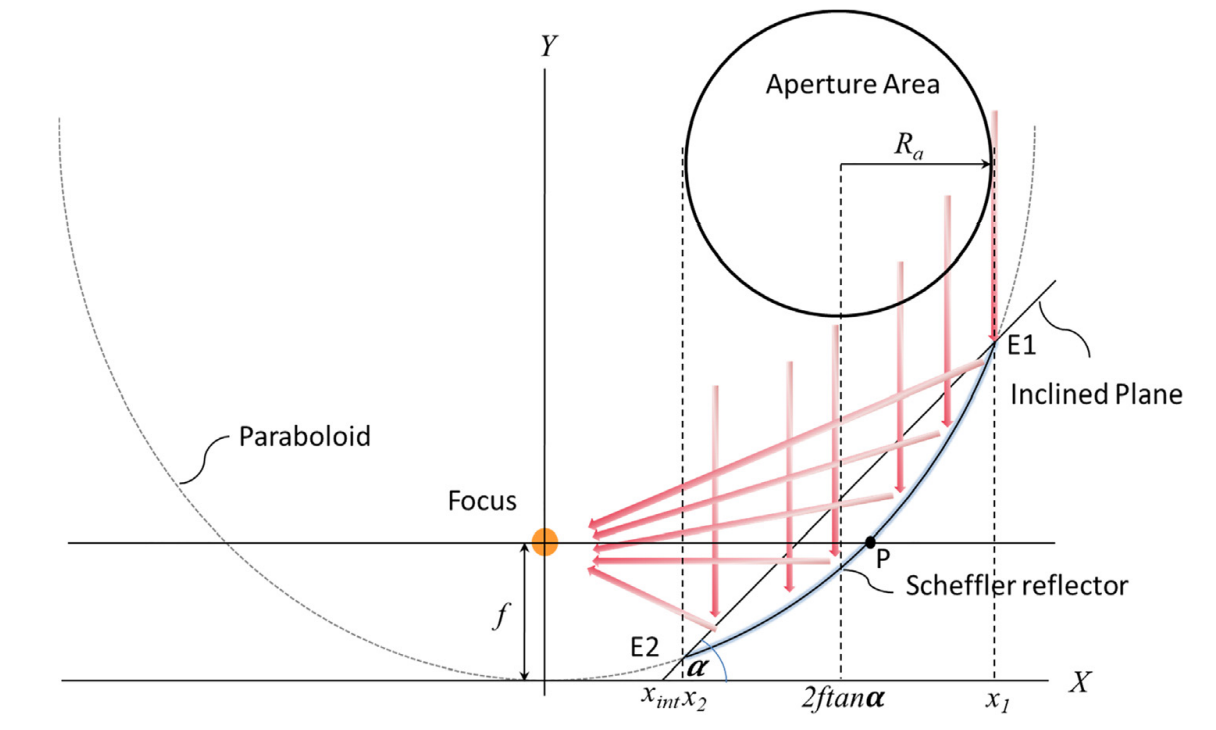

In [30]:

# Fonction pour intégrer la fonction sqrt(1 + (x/2f)^2)
def integrate_line(a, b, foyer_y, n_points):
    if a > b:
        a, b = b, a
    h = (b - a) / n_points
    total = 0
    for i in range(n_points):
        x = a + (i + 0.5) * h
        total += np.sqrt(1 + (x/(2*foyer_y))**2)
    return total * h

# Fonction pour calculer la valeur spatiale dans la parabole du réflecteur de Scheffler
def Parabole_y_n(x,m_p,C_p):
    P = m_p*x**2 + C_p #m
    return P

# Fonction permettant de calculer la valeur spatiale sur la ligne du plan de coupe du paraboloïde
def Ligne_droite(x,m_g,C_g):
    G = m_g*x + C_g #m
    return G

# Calcul de la valeur de l'angle alpha comme dans l'article de Reddy
def Calculer_pente_Reddy_1(foyer_y, R_a):
    alpha_Reddy_1 = 45 - 0.036*(R_a/foyer_y)-1.75*(R_a/foyer_y)**2
    return alpha_Reddy_1

# Calcul de la valeur de l'angle alpha comme dans l'article de Reddy
def Calculer_pente_Reddy_2(foyer_y, x_int):
    alpha_Reddy_2 = 40.1 + 4.055*(x_int/foyer_y)+0.8396*(x_int/foyer_y)**2
    return alpha_Reddy_2

# Fonction permettant de calculer la valeur de l'angle alpha pour une estimation initiale
def Calculer_pente_droite(foyer_y, R_a, Type_Evaluation):
    if Type_Evaluation == 0:
        # Doit itérer d'un angle de 42° à 44,9°
        alpha_l_min = 42 #deg
        alpha_l_max = 44.9 #deg
        scale_factor = np.pi/180 #deg -> rad
        # Informations pour le calcul itératif
        error_tol = 0.00001 #m
        alpha_l = alpha_l_min
        error = 1000
        n_points = 40
        step_min = 1e-9
        step_max = 0.05
        while (alpha_l<alpha_l_max) and (error>error_tol):
            x_E1 = 2*foyer_y*np.tan(alpha_l*scale_factor) - R_a
            x_E2 = 2*foyer_y*np.tan(alpha_l*scale_factor) + R_a
            error = abs(integrate_line(x_E1, 2*foyer_y, foyer_y, n_points) - integrate_line(2*foyer_y, x_E2, foyer_y, n_points))
            alpha_step = max(step_min, min(step_max, error * 0.1))
            alpha_l += alpha_step
        if (alpha_l>alpha_l_max):
            print("WARNING: Une valeur de pente adéquate n'a pas été obtenue")
    if Type_Evaluation == 1:
        alpha_l = Calculer_pente_Reddy_1(foyer_y, R_a)    
    return alpha_l

# Fonction permettant de calculer les paramètres de l'ellipse formée dans le plan de coupe
def Calcul_parametres_ellipse(Parametres_parabole, Parametres_ligne):
    a = np.sqrt((Parametres_ligne[0]/(2*Parametres_parabole[0]))**2 - (Parametres_parabole[1]-Parametres_ligne[1])/Parametres_parabole[0])
    ratio_angle = np.arctan(Parametres_ligne[1])
    ratio_ellipse = np.cos(ratio_angle)
    b = a/ratio_ellipse
    h = ((b-a)/(b+a))**2
    perimetre = np.pi*(a+b)*(1 + (3*h)/(10 + np.sqrt(4-3*h)))
    Parametres_ellipse = np.array([a, b, ratio_ellipse, perimetre])
    return Parametres_ellipse

# Fonction pour calculer les traverses que la structure aura autour du réflecteur
def Distribution_crossbars(Parametres_ellipse, n_crossbars_real, gap_crossbars, Parametres_ligne, Parametres_parabole, x_E1, x_E2):
    # Calcul de la distribution de la position spatiale des barres réflectrices
    x_lim = gap_crossbars*(n_crossbars_real-1)/2.
    if x_lim > Parametres_ellipse[1]:
        x_lim = Parametres_ellipse[1]
        print("WARNING: L'espacement entre les barres est incorrect")
        x_n = np.linspace(-x_lim, x_lim, n_crossbars_real+2) 
    else:
        x_n = np.linspace(-x_lim, x_lim, n_crossbars_real)    
        x_n = np.concatenate(([-Parametres_ellipse[1]], x_n, [Parametres_ellipse[1]]))
    y_n = Parametres_ellipse[2]*np.sqrt((Parametres_ellipse[1]**2 - x_n**2))
    # Calcul de la ligne imaginaire qui simule la barre transversale présente au milieu de l'ellipse
    perpendicular_angle = np.arctan(Parametres_ligne[0]) - (np.pi/2) #Pente de la ligne perpendiculaire au plan de coupe
    m_q_n = np.tan(perpendicular_angle)
    x_q_n_middle = (x_E2 + x_E1)/2
    y_q_n_middle = Ligne_droite(x_q_n_middle, Parametres_ligne[0], Parametres_ligne[1]) 
    C_q_n_middle = y_q_n_middle - x_q_n_middle*m_q_n
    ratio_ellipse_qn = np.cos(abs(perpendicular_angle))
    coefficients_quad = np.array([Parametres_parabole[0], (-m_q_n), (Parametres_parabole[1] - C_q_n_middle)]) # Intersection: y = m_p x^2 + C_p = m_g x + C_g 
    roots = np.roots(coefficients_quad)
    real_roots = roots[np.isreal(roots)].real
    x_intersect = real_roots[real_roots>=0][0]
    y_intersect = Parabole_y_n(x_intersect, Parametres_parabole[0], Parametres_parabole[1]) 
    # Calcul des autres crossbars
    C_q_vec = np.zeros(n_crossbars_real)
    a_qn_vec = np.zeros(n_crossbars_real)
    b_qn_vec = np.zeros(n_crossbars_real)
    x_n_i_middle = 0
    i_middle = int((n_crossbars_real+1)/2)
    for i in range(n_crossbars_real):
        C_q_vec[i] = (x_n[i+1] - x_n_i_middle)/np.cos(abs(perpendicular_angle)) + C_q_n_middle
        a_qn_vec[i] = np.sqrt( ((m_q_n)/(2*Parametres_parabole[0]))**2 - (Parametres_parabole[1] - C_q_vec[i])/Parametres_parabole[0] )
        b_qn_vec[i] = a_qn_vec[i]/ratio_ellipse_qn
    return x_n, y_n, m_q_n, C_q_vec, a_qn_vec, b_qn_vec, perpendicular_angle, x_intersect, y_intersect

# Processus de calcul des informations géométriques pour dimensionner les traverses du réflecteur
def Crossbars_information(n_crossbars_real, y_n, a_qn_vec, perpendicular_angle):
    delta_n = np.zeros(n_crossbars_real)
    R_n = np.zeros(n_crossbars_real)
    beta_n = np.zeros(n_crossbars_real)
    arc_n = np.zeros(n_crossbars_real)
    for i in range(n_crossbars_real):
        delta_n[i] = (a_qn_vec[i] - np.sqrt( a_qn_vec[i]**2 - y_n[i+1]**2 ) )/np.cos(perpendicular_angle)
        R_n[i] = (delta_n[i]**2 + y_n[i+1]**2)/(2*delta_n[i])
        beta_n[i] = np.arcsin(y_n[i+1]/R_n[i])
        arc_n[i] = 2*R_n[i]*(beta_n[i])    
    return delta_n, R_n, beta_n, arc_n

# Fonction permettant de déterminer l'angle d'incidence de la lumière solaire tout au long de l'année
def alpha_solar(n_year):
    principal_angle = (n_year-1)*(2*np.pi)/(365)
    alpha_rad = 0.006918 - 0.399912*np.cos(principal_angle) + 0.070257*np.sin(principal_angle) - 0.006758*np.cos(2*principal_angle) + 0.000907*np.sin(2*principal_angle) -0.002769*np.cos(3*principal_angle) + 0.00148*np.sin(3*principal_angle) 
    alpha_deg = (180/np.pi)*(alpha_rad)
    return alpha_rad

# Fonction pour calculer la valeur z spatiale du paraboloïde calculé    
def Paraboloide_rev(x,y,Parametres_parabole):
    f = Parametres_parabole[0]*(x**2+y**2) + Parametres_parabole[1]
    return f

# Fonction permettant de déterminer la dérivée partielle de la fonction paraboloïde par rapport à l'axe des x
def dev_Paraboloide_rev_x(x,y,Parametres_parabole):
    dz_dx = 2*Parametres_parabole[0]*x
    return dz_dx

# Fonction permettant de déterminer la dérivée partielle de la fonction paraboloïde par rapport à l'axe des y
def dev_Paraboloide_rev_y(x,y,Parametres_parabole):
    dz_dy = 2*Parametres_parabole[0]*y
    return dz_dy

# Fonction permettant de déterminer l'aire de la surface dans l'espace 3D
def valeur_surface(Parametres_parabole, a_cercle, r_cercle, n_x, n_y):
    delta_x = (2*r_cercle)/(n_x-1)
    delta_y = (2*r_cercle)/(n_y-1)
    dA = delta_x*delta_y
    sum_int = 0
    for j in range(n_x-1):
        for i in range(n_y-1):
            x_j = a_cercle - r_cercle + (j)*delta_x/2 + delta_x/2
            y_i = r_cercle - (i)*delta_y/2 - delta_y/2
            if (x_j - a_cercle)**2 + y_i**2 <= r_cercle**2:
                sum_int = sum_int + dA*np.sqrt(1 + dev_Paraboloide_rev_x(x_j,y_i,Parametres_parabole)**2 + dev_Paraboloide_rev_y(x_j,y_i,Parametres_parabole)**2)
    return sum_int

# Fonction permettant de déterminer une rotation d'un point bidimensionnel avec un angle alpha (règle de la main droite) et autour du point focal
def determine_rotation(x_parabola, y_parabola, alpha, f_point_x, f_point_y):
    x_parabola_tr = x_parabola - f_point_x
    y_parabola_tr = y_parabola - f_point_y
    Matrix = np.array([[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.cos(alpha)]])
    coordinates = np.array([x_parabola_tr, y_parabola_tr])
    new_coordinates = np.dot(coordinates, Matrix)
    x_parabola_new = new_coordinates[0] + f_point_x
    y_parabola_new = new_coordinates[1] + f_point_y
    return x_parabola_new, y_parabola_new

# Determinar los parámetros de la parabola en el equinnocio
def Determiner_Parabole_equinnoxe(foyer_y, A_approx, n_crossbars_real, gap_crossbars):
    # Calculer les paramètres du réflecteur de Scheffleur
    y_p = foyer_y
    x_p = 2*foyer_y 
    dev_P = 1
    m_p = dev_P/(2*x_p)
    C_p = 0
        # Calculer le foyer de la parabole
    f_point_x_equinnoxe = 0.0 # x_h = 0
    f_point_y_equinnoxe = 1./(4*m_p)
    f_spatial_point_equinnoxe = np.array([f_point_x_equinnoxe, f_point_y_equinnoxe])
    Point_P_equinnoxe = np.array([x_p, y_p])
    Parametres_parabole_equinnoxe = np.array([m_p, C_p, f_spatial_point_equinnoxe, Point_P_equinnoxe], dtype=object)
    
    # Processus itératif pour calculer les valeurs des paramètres de la ligne du plan de coupe du paraboloïde
    R_a = np.sqrt(A_approx/np.pi)
    scale_factor = np.pi/180 #deg -> rad
    alpha_deg = Calculer_pente_droite(foyer_y, R_a, 0) #0 : Itératif, 1: Reddy's formula
    x_E1 = 2*foyer_y*np.tan(alpha_deg*scale_factor) - R_a
    x_E2 = 2*foyer_y*np.tan(alpha_deg*scale_factor) + R_a
    y_E1 = Parabole_y_n(x_E1, Parametres_parabole_equinnoxe[0], Parametres_parabole_equinnoxe[1]) 
    y_E2 = Parabole_y_n(x_E2, Parametres_parabole_equinnoxe[0], Parametres_parabole_equinnoxe[1])
    m_g = (y_E2 - y_E1)/(x_E2 - x_E1) #41° - 44.9°
    C_g = y_E1-m_g*x_E1
    Parametres_ligne_equinnoxe = np.array([m_g, C_g, alpha_deg, np.array([x_E1,y_E1]), np.array([x_E2,y_E2])], dtype=object)
    
    # Calculer les paramètres de l'ellipse formée dans le plan de coupe
    a = (x_E2-x_E1)/2 #np.sqrt((Parametres_ligne_equinnoxe[0]/(2*Parametres_parabole_equinnoxe[0]))**2 - (Parametres_parabole_equinnoxe[1]-Parametres_ligne_equinnoxe[1])/Parametres_parabole_equinnoxe[0])
    ratio_angle = np.arctan(m_g)
    ratio_ellipse = np.cos(ratio_angle) #r_e = a/b
    b = a/ratio_ellipse
    b_n = np.sqrt((x_E2-x_E1)**2 + (y_E2-y_E1)**2)/2
    Surface_equinnoxe_plan_coupe = np.pi*a*b
    h = ((b-a)/(b+a))**2
    perimetre = np.pi*(a+b)*(1 + (3*h)/(10 + np.sqrt(4-3*h)))
    Parametres_ellipse_equinnoxe = np.array([a, b, ratio_ellipse, perimetre, Surface_equinnoxe_plan_coupe], dtype=object)
    
    # Calcul des informations des crossbars
    x_n, y_n, m_q_n, C_q_vec, a_qn_vec, b_qn_vec, perpendicular_angle, x_intersect, y_intersect = Distribution_crossbars(Parametres_ellipse_equinnoxe, n_crossbars_real, gap_crossbars, Parametres_ligne_equinnoxe, Parametres_parabole_equinnoxe, x_E1, x_E2)
    delta_n, R_n, beta_n, arc_n = Crossbars_information(n_crossbars_real, y_n, a_qn_vec, perpendicular_angle)
    Parametres_crossbars_equinnoxe = np.array([x_n, y_n, m_q_n, C_q_vec, a_qn_vec, b_qn_vec, perpendicular_angle, delta_n, R_n, beta_n, arc_n], dtype=object)
    
    # Calcul de la surface du réflecteur
    r_cercle = Parametres_ellipse_equinnoxe[0]
    a_cercle = x_E1 + r_cercle
    surface = valeur_surface(Parametres_parabole_equinnoxe, a_cercle, r_cercle, 1000, 1000)
    return Parametres_parabole_equinnoxe, Parametres_ligne_equinnoxe, Parametres_ellipse_equinnoxe, Parametres_crossbars_equinnoxe

# Fonction permettant de calculer la forme de la parabole, du plan de coupe et de la forme de l'ellipse résultante en fonction du jour de l'année
def Determiner_Parabole_saison(n_year, Parametres_parabole_equinnoxe, Parametres_ligne_equinnoxe, Parametres_ellipse_equinnoxe):
    # Equinnnoxe information
    f_point_y_equinnoxe = Parametres_parabole_equinnoxe[2][1]
    x_p_equinnoxe = Parametres_parabole_equinnoxe[3][0]
    y_p_equinnoxe = Parametres_parabole_equinnoxe[3][1]
    alpha_year = alpha_solar(n_year)
    f_n = f_point_y_equinnoxe*(1-np.cos(np.pi/2 - alpha_year))
    m_saison = 1/(4*f_n)
    C_saison = f_point_y_equinnoxe-f_n
    f_spatial_point_saison = np.array([Parametres_parabole_equinnoxe[2][0], f_n])
    Point_P_saison = np.array([x_p_equinnoxe*np.cos(alpha_year),(x_p_equinnoxe*np.cos(alpha_year))**2/(4*f_n)+ (f_point_y_equinnoxe-f_n)])
    Parametres_parabole_saison = np.array([m_saison, C_saison, f_spatial_point_saison, Point_P_saison], dtype=object)
    
    # Calculer les nouveaux points d'intersection du plan
    n_points = 100
    I_E1_equinnoxe = integrate_line(Parametres_ligne_equinnoxe[3][0], x_p_equinnoxe, f_point_y_equinnoxe, n_points)
    I_E2_equinnoxe = integrate_line(x_p_equinnoxe, Parametres_ligne_equinnoxe[4][0], f_point_y_equinnoxe, n_points)
    def objective_E1(x_inic_new):
        result = integrate_line(x_inic_new, Point_P_saison[0], f_n, n_points)
        return result - I_E1_equinnoxe
    def objective_E2(x_inic_new):
        result = integrate_line(Point_P_saison[0], x_inic_new, f_n, n_points)
        return result - I_E2_equinnoxe
    tol_method = 1e-8
    x_E1_n = root_scalar(objective_E1, bracket=[0, Point_P_saison[0]], method='brentq', xtol=tol_method).root
    x_E2_n = root_scalar(objective_E2, bracket=[Point_P_saison[0], Parametres_ligne_equinnoxe[4][0]*4], method='brentq', xtol=tol_method).root
    y_E1_n = Parabole_y_n(x_E1_n, Parametres_parabole_saison[0], Parametres_parabole_saison[1]) 
    y_E2_n = Parabole_y_n(x_E2_n, Parametres_parabole_saison[0], Parametres_parabole_saison[1])
    b_n = np.sqrt((x_E2_n-x_E1_n)**2 + (y_E2_n-y_E1_n)**2)/2
    a_n = Parametres_ellipse_equinnoxe[4]/(np.pi*b_n)
    ratio_ellipse_n = a_n/b_n
    Surface_n_plan_coupe = np.pi*a_n*b_n
    h = ((b_n-a_n)/(b_n+a_n))**2
    perimetre_n = np.pi*(a_n+b_n)*(1 + (3*h)/(10 + np.sqrt(4-3*h)))
    m_g_n = (y_E2_n - y_E1_n)/(x_E2_n - x_E1_n) #41° - 44.9°
    C_g_n = y_E1_n-m_g_n*x_E1_n
    alpha_deg_n = np.arctan(m_g_n)*180/np.pi
    Parametres_ligne_saison = np.array([m_g_n, C_g_n, alpha_deg_n, np.array([x_E1_n,y_E1_n]), np.array([x_E2_n,y_E2_n])], dtype=object)
    
    # Calculer des vecteurs pour identifier le plan de coupe spatialement
    alpha_rad_n = alpha_deg_n*np.pi/180
    U_ellipse_n = np.array([np.cos(alpha_rad_n),np.sin(alpha_rad_n),0])
    V_ellipse_n = np.array([0,0,1])
    C_ellipse_n = np.array([(x_E2_n + x_E1_n)/2,(y_E2_n + y_E1_n)/2,0])
    Parametres_ellipse_saison = np.array([a_n, b_n, ratio_ellipse_n, perimetre_n, Surface_n_plan_coupe, U_ellipse_n, V_ellipse_n, C_ellipse_n], dtype=object)
    return Parametres_parabole_saison, Parametres_ligne_saison, Parametres_ellipse_saison

# Fonction permettant de déterminer le nombre de miroirs à placer dans chaque section de miroir
def Determiner_nombre_miroirs(Parametres_parabole_saison, Parametres_ligne_saison, Parametres_ellipse_saison, Parametres_parabole_equinnoxe, lon_miroir, step_y=0.0001):
    alpha_rad_n = Parametres_ligne_saison[2]*np.pi/180
    a_n = Parametres_ellipse_saison[0] #(b_n para nosotros)
    b_n = Parametres_ellipse_saison[1] #(a_n para nosotros)
    f_n = Parametres_parabole_saison[2][1]
    f_equinnoxe = Parametres_parabole_equinnoxe[2][1]
    U_ellipse_n = Parametres_ellipse_saison[5]
    V_ellipse_n = Parametres_ellipse_saison[6]
    C_ellipse_n = Parametres_ellipse_saison[7]
    
    # Fonction de calcul en x renvoyant une valeur de la parabole y (demi-axe positif)
    def y_to_x(y):
        return np.sqrt(4*f_n*(y-(f_equinnoxe-f_n)))
    
    # Calculer les coordonnées y [ymin,ymax] du profil parabolique où la largeur de la crossbar est égale à lon_miroir
    x_val = b_n*np.sqrt(1-(lon_miroir/(2*a_n))**2)
    x = np.array([x_val,-x_val])
    yl = x*np.sin(alpha_rad_n)+C_ellipse_n[1]
    xl = y_to_x(yl)
    
    # Processus pour diviser le profil parabolique entre ymin, ymax en segments de taille lon_miroir
    y_vals = [yl[0]]
    x_vals = [xl[0]]
    i = 0
    while y_vals[i] >= yl[1]:
        x_i = y_to_x(y_vals[i])
        y2 = y_vals[i]
        x2 = x_i
        d = 0
        # Chaque crossbar est supposée reposer sur le coin supérieur de chaque segment
        while d <= lon_miroir:
            d = np.sqrt((x_vals[i]-x2)**2+(y_vals[i]-y2)**2)
            y2 -= step_y
            x2 = y_to_x(y2)
        if y2 >= yl[1]:
            y_vals.append(y2)
            x_vals.append(x2)
            i += 1
        else:
            break
    # Calculer les informations géométriques des crossbars dans l'espace
    Rayon_crossbar = np.array(x_vals)
    x_proj = (np.array(y_vals)-C_ellipse_n[1])/np.sin(alpha_rad_n) # Distance de C_ellipse_n le long de l'axe majeur
    #t = np.arccos(x_proj/a_n)
    coords_spatial_x = np.abs(np.array(y_vals)/np.tan(alpha_rad_n))
    coords_spatial_y = np.array(y_vals)
    coords_spatial_z = a_n*np.sqrt(1-(x_proj/b_n)**2)
    positions_spaciales_miroirs = np.vstack((coords_spatial_x,coords_spatial_y,coords_spatial_z)).T
    demiangle_soustendu_crossbars = np.degrees(np.arcsin(positions_spaciales_miroirs[:,2]/Rayon_crossbar))
    angle_soustendu_miroirs = 2*np.degrees(np.arcsin(lon_miroir/(2*Rayon_crossbar)))
    nombre_miroirs = np.floor(2*demiangle_soustendu_crossbars/angle_soustendu_miroirs).astype(int)
    return positions_spaciales_miroirs, Rayon_crossbar, demiangle_soustendu_crossbars, angle_soustendu_miroirs, nombre_miroirs

# Calculez si les 4 points résultants sont coplanaires
def Sont_coplanaires(Am, Bm, Cm, Dm, tol=1e-8):
    AB = Bm - Am
    AC = Cm - Am
    AD = Dm - Am
    volumen = np.dot(AB, np.cross(AC, AD))
    return abs(volumen) < tol

# Calculer le vecteur normal et le centre des plans résultant de la discrétisation du réflecteur
def Vecteur_normal_plan(Am, Bm, Cm, Dm):
    v1 = Bm - Am
    v2 = Dm - Am
    Centre_m = (0.25)*(Am+Bm+Cm+Dm)
    normal = np.cross(v1, v2)
    normal_unitaire = normal / np.linalg.norm(normal)
    return Centre_m, normal_unitaire

# Modifiez les axes de position des points résultants qui forment la structure du réflecteur
def Swap_axes(Mtile, ordre=(0, 2, 1)):
    Mtile_modifie = []
    for points in Mtile:
        nouveaux_points = [p[list(ordre)] for p in points]
        Mtile_modifie.append(nouveaux_points)
    return Mtile_modifie

def plot_3d_points(Mtile):
    # Crear una figura para la gráfica 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    i=0
    # Iterar sobre cada conjunto de puntos (Am, Bm, Cm, Dm)
    for points in Mtile:
        Am, Bm, Cm, Dm = points  # Extraer cada conjunto de puntos
        # Graficar los puntos en 3D
        #ax.scatter(Am[0], Am[1], Am[2], color='r')
        #ax.scatter(Bm[0], Bm[1], Bm[2], color='g')
        #ax.scatter(Cm[0], Cm[1], Cm[2], color='b')
        #ax.scatter(Dm[0], Dm[1], Dm[2], color='y')
        ax.plot([Am[0], Bm[0]], [Am[1], Bm[1]], [Am[2], Bm[2]], color='r')  # Línea Am-Bm
        ax.plot([Bm[0], Cm[0]], [Bm[1], Cm[1]], [Bm[2], Cm[2]], color='g')  # Línea Bm-Cm
        ax.plot([Cm[0], Dm[0]], [Cm[1], Dm[1]], [Cm[2], Dm[2]], color='b')  # Línea Cm-Dm
        ax.plot([Dm[0], Am[0]], [Dm[1], Am[1]], [Dm[2], Am[2]], color='y')  # Línea Dm-Am
    # Etiquetas y título
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Gráfica 3D de los puntos')

    ax.view_init(elev=15, azim=140)
    # Mostrar la gráfica
    plt.show()

# Routine pour calculer la distribution des miroirs
def Determiner_distribution_miroirs(positions_spaciales_miroirs, Rayon_crossbar, demiangle_soustendu_crossbars, angle_soustendu_miroirs, nombre_miroirs):    
    e = positions_spaciales_miroirs
    Rm = Rayon_crossbar
    ha = demiangle_soustendu_crossbars
    ma = angle_soustendu_miroirs
    nm = nombre_miroirs
    Uhc = np.array([1, 0, 0])
    Vhc = np.array([0, 0, 1])
    Mtile = []
    k = 0
    for i in range(len(nm)):
        if e[i,2] < e[i + 1,2]:
            mac = np.linspace(-ha[i], ha[i], nm[i]+1)
            for j in range(nm[i]):
                Dm = np.zeros(3)
                Dm[0] = Rm[i] * (np.cos(np.radians(mac[j])) * Uhc[0] + np.sin(np.radians(mac[j])) * Vhc[0])
                Dm[1] = e[i,1] + Rm[i] * (np.cos(np.radians(mac[j])) * Uhc[1] + np.sin(np.radians(mac[j])) * Vhc[1])
                Dm[2] = Rm[i] * (np.cos(np.radians(mac[j])) * Uhc[2] + np.sin(np.radians(mac[j])) * Vhc[2])
                Cm = np.zeros(3)
                angle = mac[j] + ma[i]
                Cm[0] = Rm[i] * (np.cos(np.radians(angle)) * Uhc[0] + np.sin(np.radians(angle)) * Vhc[0])
                Cm[1] = e[i,1] + Rm[i] * (np.cos(np.radians(angle)) * Uhc[1] + np.sin(np.radians(angle)) * Vhc[1])
                Cm[2] = Rm[i] * (np.cos(np.radians(angle)) * Uhc[2] + np.sin(np.radians(angle)) * Vhc[2])
                m = -(Dm[0] - Cm[0]) / (Dm[2] - Cm[2])
                def eqn_1(fy):
                    return Rm[i+1] * np.sin(fy) - Dm[2] - m * (Rm[i + 1] * np.cos(fy) - Dm[0])
                fy_initial_guess = 0.0
                angle_rad = fsolve(eqn_1, fy_initial_guess)
                angle_deg = np.degrees(angle_rad)
                Am = None
                if abs(angle_deg) < ha[i + 1]:
                    Am = np.zeros(3)
                    Am[0] = Rm[i+1] * np.cos(angle_rad[0])
                    Am[1] = e[i+1,1]
                    Am[2] = Rm[i+1] * np.sin(angle_rad[0])
                if Am is None:
                    continue
                Bm = Am + (Cm - Dm)
                Mtile.append([Am, Bm, Cm, Dm])
                k += 1
        else:
            break
    for i in range(len(nm)-1, -1, -1):
        if e[i,2] < e[i-1,2]:
            mac = np.linspace(-ha[i], ha[i], nm[i] + 1)
            for j in range(nm[i]):
                Am = np.zeros(3)
                Am[0] = Rm[i] * (np.cos(np.radians(mac[j])) * Uhc[0] + np.sin(np.radians(mac[j])) * Vhc[0])
                Am[1] = e[i][1] + Rm[i] * (np.cos(np.radians(mac[j])) * Uhc[1] + np.sin(np.radians(mac[j])) * Vhc[1])
                Am[2] = Rm[i] * (np.cos(np.radians(mac[j])) * Uhc[2] + np.sin(np.radians(mac[j])) * Vhc[2])
                angle = mac[j] + ma[i]
                Bm = np.zeros(3)
                Bm[0] = Rm[i] * (np.cos(np.radians(angle)) * Uhc[0] + np.sin(np.radians(angle)) * Vhc[0])
                Bm[1] = e[i][1] + Rm[i] * (np.cos(np.radians(angle)) * Uhc[1] + np.sin(np.radians(angle)) * Vhc[1])
                Bm[2] = Rm[i] * (np.cos(np.radians(angle)) * Uhc[2] + np.sin(np.radians(angle)) * Vhc[2])
                m = -(Am[0] - Bm[0]) / (Am[2] - Bm[2])
                def eqn_2(fy):
                    return Rm[i-1] * np.sin(fy) - Am[2] - m * (Rm[i-1] * np.cos(fy) - Am[0])
                fy_initial_guess = 0.0
                angle_rad = fsolve(eqn_2, fy_initial_guess)
                angle_deg = np.degrees(angle_rad)
                Dm = np.zeros(3)
                Dm[0] = Rm[i-1] * np.cos(angle_rad[0])
                Dm[1] = e[i-1,1]
                Dm[2] = Rm[i-1] * np.sin(angle_rad[0])
                Cm = Dm + (Bm - Am)
                Mtile.append([Am, Bm, Cm, Dm])
                k += 1
        else:
            break
        Mtile_modifie = Swap_axes(Mtile)
    return Mtile_modifie

# Fonction pour définir les matrices de plans de réflexion
def Calculer_plans_de_simulation_raytracing(Mtile, lon_miroir):
    Matriz_Point_C = []
    Matriz_L_xy = []
    Matriz_vec_normal = []
    for points in Mtile:
        Am, Bm, Cm, Dm = points
        Centre_m, normal_unitaire = Vecteur_normal_plan(Am, Bm, Cm, Dm)
        Matriz_Point_C.append(Centre_m)
        Matriz_L_xy.append([lon_miroir, lon_miroir])
        Matriz_vec_normal.append(normal_unitaire)
    return Matriz_Point_C, Matriz_L_xy, Matriz_vec_normal
        

# Fonction permettant de calculer la rotation du réflecteur en fonction du jour de l'année
def faire_pivoter_les_plans_autour_de_y(M_tile, angle_rad, f_y):
    rotation = R.from_rotvec(angle_rad * np.array([0, 1, 0]))
    M_tile_rotate = []
    for quad in M_tile:
        quad_rotate = []
        for point in quad:
            # Translation vers l'origine focale
            point_translaté = point - np.array([0, 0, f_y])
            # Application de la rotation
            point_tourné = rotation.apply(point_translaté)
            # Retour à la position initiale
            point_final = point_tourné + np.array([0, 0, f_y])
            quad_rotate.append(point_final)
        M_tile_rotate.append(quad_rotate)
    return M_tile_rotate

def Calculer_parabole_réfléchissante_adéquate(foyer_y, A_approx, n_crossbars_real, gap_crossbars, n_year, lon_miroir):
    Parametres_parabole_equinnoxe, Parametres_ligne_equinnoxe, Parametres_ellipse_equinnoxe, Parametres_crossbars_equinnoxe = Determiner_Parabole_equinnoxe(foyer_y, A_approx, n_crossbars_real, gap_crossbars)
    
    alpha_year = alpha_solar(n_year)
    # Calcular la parabola para el invierno
    n_hiver = 355
    Parametres_parabole_hiver, Parametres_ligne_hiver, Parametres_ellipse_hiver = Determiner_Parabole_saison(n_hiver, Parametres_parabole_equinnoxe, Parametres_ligne_equinnoxe, Parametres_ellipse_equinnoxe)
    positions_spaciales_miroirs, Rayon_crossbar, demiangle_soustendu_crossbars, angle_soustendu_miroirs, nombre_miroirs_hiver = Determiner_nombre_miroirs(Parametres_parabole_hiver, Parametres_ligne_hiver, Parametres_ellipse_hiver, Parametres_parabole_equinnoxe, lon_miroir)
    
    # Calcular la parabola para el verano
    n_ete = 172
    Parametres_parabole_ete, Parametres_ligne_ete, Parametres_ellipse_ete = Determiner_Parabole_saison(n_ete, Parametres_parabole_equinnoxe, Parametres_ligne_equinnoxe, Parametres_ellipse_equinnoxe)
    positions_spaciales_miroirs, Rayon_crossbar, demiangle_soustendu_crossbars, angle_soustendu_miroirs, nombre_miroirs_ete = Determiner_nombre_miroirs(Parametres_parabole_ete, Parametres_ligne_ete, Parametres_ellipse_ete, Parametres_parabole_equinnoxe, lon_miroir)
    
    # Calcular la parabola para el día seleccionado
    Parametres_parabole_saison, Parametres_ligne_saison, Parametres_ellipse_saison = Determiner_Parabole_saison(n_year, Parametres_parabole_equinnoxe, Parametres_ligne_equinnoxe, Parametres_ellipse_equinnoxe)
    positions_spaciales_miroirs, Rayon_crossbar, demiangle_soustendu_crossbars, angle_soustendu_miroirs, nombre_miroirs = Determiner_nombre_miroirs(Parametres_parabole_saison, Parametres_ligne_saison, Parametres_ellipse_saison, Parametres_parabole_equinnoxe, lon_miroir)
    
    # Determinar el número de espejos a utilizar
    nombre_miroirs_hiver = np.array(nombre_miroirs_hiver)
    nombre_miroirs_ete = np.array(nombre_miroirs_ete)
    len_hiver = len(nombre_miroirs_hiver)
    len_ete = len(nombre_miroirs_ete)
    max_len = max(len_hiver, len_ete)
    if len_hiver < max_len:
        nombre_miroirs_hiver = np.pad(nombre_miroirs_hiver, (0, max_len - len_hiver), mode='constant')
    if len_ete < max_len:
        nombre_miroirs_ete = np.pad(nombre_miroirs_ete, (0, max_len - len_ete), mode='constant')
    nombre_miroirs = np.minimum(nombre_miroirs_hiver, nombre_miroirs_ete)

    print(len(nombre_miroirs))
    M_tile = Determiner_distribution_miroirs(positions_spaciales_miroirs, Rayon_crossbar, demiangle_soustendu_crossbars, angle_soustendu_miroirs, nombre_miroirs)
    M_tile = faire_pivoter_les_plans_autour_de_y(M_tile, alpha_year, foyer_y)
    plot_3d_points(M_tile)
    Matriz_Point_C, Matriz_L_xy, Matriz_vec_normal = Calculer_plans_de_simulation_raytracing(M_tile, lon_miroir)

    return Matriz_Point_C, Matriz_L_xy, Matriz_vec_normal
    
    


# Résoudre

9


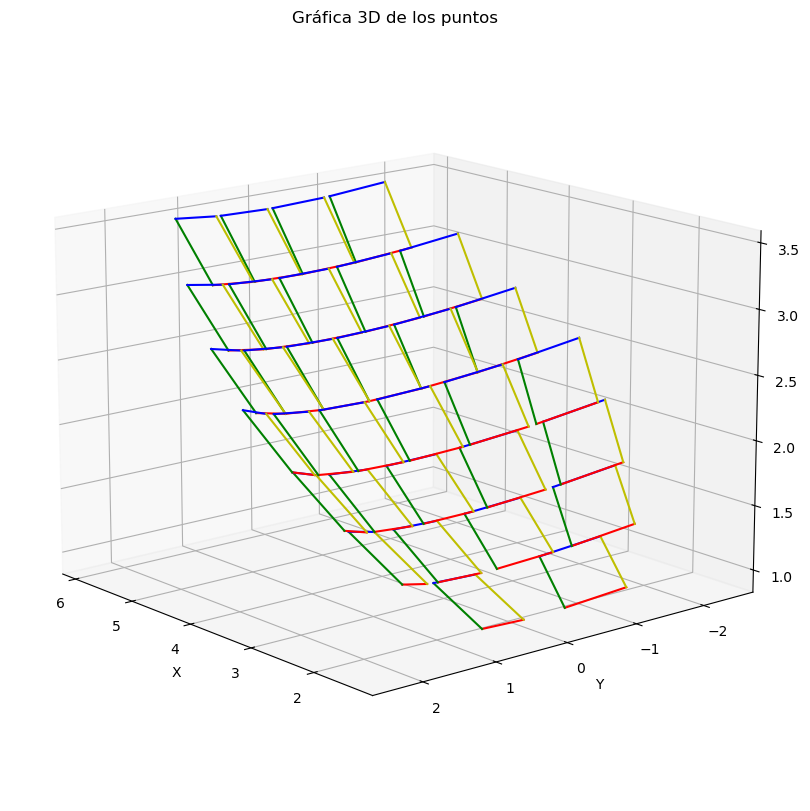

In [33]:
foyer_y = 2 #m
A_approx = 16 #m^2
n_crossbars_real = 8 #impair
gap_crossbars = 0.05 #m
n_year = 172
lon_miroir = 0.7

Matriz_Point_C, Matriz_L_xy, Matriz_vec_normal = Calculer_parabole_réfléchissante_adéquate(foyer_y, A_approx, n_crossbars_real, gap_crossbars, n_year, lon_miroir)
